# Assignment 2
## ISPR 23/24, third assignment
### by Andrea Marino (matr. 561935)

### Preliminary stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
#from PIL import Image              # Python Image Library

In [2]:
if(colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "drive/MyDrive/ISPR/Compitini ISPR/Terzo Compitino/"
    sys.path.insert(0,BASE_PATH)
    #os.chdir(BASE_PATH)
    #!pip install -U torch           # update PyTorch
    #!pip install -U torchvision     # update torchvision
else:
    BASE_PATH = ""


In [3]:
import torch
from torch import nn

Let's also set PyTorch's seed to a fixed value, for reproducibility but also to get the same splits in the datasets we're going to create

In [4]:
torch.manual_seed(42)

Finally, we define the device.

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

### Data, Dataset and Dataloaders

Since I already used the dataset for the first assignment, I don't need to download it again. I just have to fetch it from the right directory (in a way that deals with both Colab and my local install)

In [5]:
HORSE_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/horse/")
MASK_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/mask/")

HORSE_PATH, MASK_PATH

('../Primo Compitino/weizmann_horse_db/horse/',
 '../Primo Compitino/weizmann_horse_db/mask/')

Let's create the class for the dataset, as required by PyTorch.

We can also apply transformations on our data. The principal transformation worth talking about has to deal with the batch size and the shape of the images. 

If in our `DataLoader`s the batch size is set to be greater than 1, then the images have to be of the same shape (height * width), otherwise the associated tensors can't be stacked in a single batch tensor. This is unfortunate, we can deal with it in three ways:
1. Always online learning algorithm (aka batch_size=1)
2. Resize the image
3. Add a padding of zeros to the smaller images, to bring them all to the same size as the bigger image in the dataset (and then let the model deal with the extra padding).

All three options are interesting for their own reasons, so writing a more general code that allows one to apply each of the ideas is worthwhile.

The first option allows to assess the model's performance on images of different sizes, an interesting challenge for sure. The second option is the most promising and most powerful one, as torchvision's tools seems to do a good job at resizing both the images and the mask, upon preliminary checking. The third option is pretty rough, but it might be interesting to see how the model performs in this case.

In [14]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class HorseDataset(Dataset):
    def __init__(self, 
                 image_path=HORSE_PATH,
                 mask_path=MASK_PATH,
                 transform=None,
                 target_transform=None):
        self.img_dir = image_path
        self.mask_dir = mask_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # We know that the answer is 327 but let's make it
        # more general and structured
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path, mask_path = self._horsePath(idx+1)
        img = read_image(img_path)      # WIP!!
        mask = read_image(mask_path)    # WIP!!
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        return img, mask
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__getitem__(i)    
    
    def _horsePath(self, h:int):
        '''
        Returns the path to the horse image
        whose number (in the filename) is h
        '''
        number = "0"*(2-int(np.log10(h)))+str(h)
        imgname = "horse" + number + ".png"
        img_path = self.img_dir + imgname
        mask_path = self.mask_dir + imgname
        return img_path, mask_path

To apply the transformations as described, we need the height and width of the biggest and smallest images in the dataset.

In [23]:
plain_dataset = HorseDataset()

MAX, MIN = (0,0), (np.inf,np.inf)
biggest, smallest = -1,-1

for i, (img, _) in enumerate(plain_dataset,start=1):
    img_h, img_w = tuple(img.shape[1:])
    if img_h*img_w > MAX[0]*MAX[1]:
        MAX = (img_h, img_w)
        biggest = i
    if img_h*img_w < MIN[0]*MIN[1]:
        MIN = (img_h, img_w)
        smallest = i

print(f"The biggest image is horse {biggest}, of size {max[0]}x{max[1]}")
print(f"The smallest image is horse {smallest}, of size {min[0]}x{min[1]}")

The biggest image is horse 65, of size 960x1280
The smallest image is horse 16, of size 148x231


#### Horse dataset of unchanged images

We create a dataset following the first option.

We can use the `random_split` to create the training set and the test set. 

20% of the whole dataset is held out as test set. I chose this approach over cross-validation to alleviate the computational burden.

In [ ]:
from torch.utils.data import random_split

# Create the developement and test datasets
train_size = int(0.8 * len(plain_dataset))
test_size = len(plain_dataset) - train_size

training_plain_dataset, test_plain_dataset = random_split(plain_dataset, [train_size, test_size])

Now we can create the DataLoaders for the training and test data, using batch size of 1 since we applied no transformation

In [ ]:
from torch.utils.data import DataLoader

# Attenzione:
BATCH_SIZE = 1

train_plain_dataloader = DataLoader(training_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_plain_dataloader = DataLoader(test_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Horse dataset of resized images

Let's see how the `HorseDataset` class allows us to create a dataset of resized images.

In [8]:
from torchvision.transforms import Lambda, Resize

resize_transform = lambda h,w: Lambda(lambda X: Resize((h,w))(X))

In [12]:
# We can resize to the smallest, or choose any other size
h, w = 256, 256

dataset_resized = HorseDataset(transform=resize_transform(h,w), 
                              target_transform=resize_transform(h,w))

for img, mask in dataset_resized:
    assert img.shape == (3,h,w) and mask.shape == (1,h,w)

print("All images and masks have been resized correctly")

All images and masks have been resized correctly


DataLoader creation:


In [ ]:
training_resized_dataset, test_resized_dataset = random_split(dataset_resized, [train_size, test_size])

BATCH_SIZE = 4

train_resized_dataloader = DataLoader(training_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_resized_dataloader = DataLoader(test_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(f"Training: n° images is {len(train_plain_dataloader.dataset)}, n° of minibatches is: {len(test_plain_dataloader)}")
print(f"Test: n° images is {len(test_plain_dataloader.dataset)}, n° of minibatches is: {len(test_plain_dataloader)}")

for X, y in train_plain_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: [N, C, H, W]", y.shape, y.dtype)
    break

Training: n° images is 261, n° of minibatches is: 66
Test: n° images is 66, n° of minibatches is: 66


#### Horse dataset of padded images

Lastly, we create a dataset of padded images using the `HorseDataset` class.

Instead of passing a fixed amount of padding to the transformation, we pass it the target height and width of the image.

In [11]:
from torchvision.transforms import Pad

pad_transform = lambda target_h, target_w: Lambda(lambda X: Pad((X.shape[1]-target_h, X.shape[2]-target_w), fill=0)(X))

In [ ]:
h, w = MAX

dataset_padded = HorseDataset(transform=pad_transform(h,w), 
                              target_transform=pad_transform(h,w))

# Check that things are ok

DataLoader creation:

In [ ]:
training_padded_dataset, test_padded_dataset = random_split(dataset_padded, [train_size, test_size])

BATCH_SIZE = 4

train_padded_dataloader = DataLoader(training_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_padded_dataloader = DataLoader(test_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Intermezzo: resizing

In [25]:
img0, mask0 = training_plain_dataset[0]
img0.shape, mask0.shape

(torch.Size([3, 289, 245]), torch.Size([1, 289, 245]))

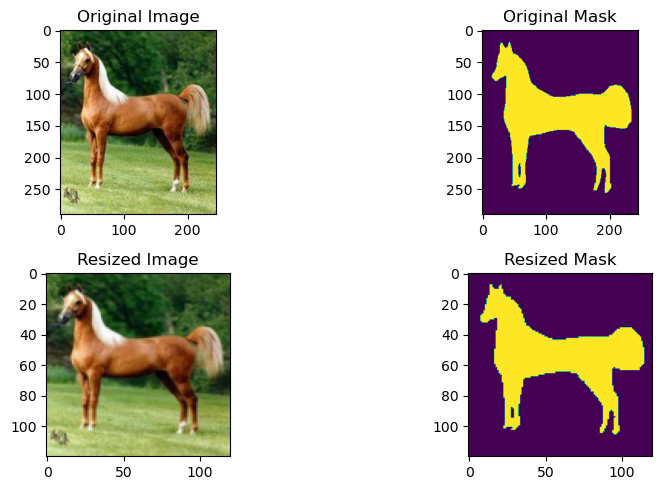

In [26]:
h, w = 120, 200

rsz_img0, rsz_mask0 = Resize((h,w))(img0), Resize((h,w))(mask0)

fig, ax = plt.subplots(2,2, figsize=(10,5))
ax = ax.ravel()
ax[0].imshow(img0.permute(1,2,0))
ax[0].set_title("Original Image")
ax[1].imshow(mask0.permute(1,2,0))
ax[1].set_title("Original Mask")
ax[2].imshow(rsz_img0.permute(1,2,0))
ax[2].set_title("Resized Image")
ax[3].imshow(rsz_mask0.permute(1,2,0))
ax[3].set_title("Resized Mask")

plt.tight_layout()
plt.show()

### The model

The task is semantic segmentation of the horse from the background. The chosen model for this task is a *U-shaped network* that uses convolution and deconvolution. Given the context, such a network could be referred as a horseshoe network.

In [ ]:
class HorseshoeNetwork(nn.Module):
    # Copilot suggestion:
    """ def __init__(self):
        super(HorseshoeNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 1, 3, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.sigmoid(self.conv7(x))
        return x """